# Kilosort 4

Run the spike sorting pipeline including:
* **CatGT** - extract the sync signal from each probe
* **Kilosort4** - sorting the neural data
* **TPrime** - alignment of all the probe timings to one another using the sync signal from CatGT

***
## Import and Install Libraries

In [10]:
import os
import re
import sys
import time
import warnings
import argparse
import subprocess
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib import gridspec, rcParams
warnings.simplefilter("ignore")
# install kilosort
# !pip install kilosort
from kilosort import run_kilosort
ks_path = os.getcwd()

***
## Find Recording Folders

In [3]:
def read_recording_folder(session_params):
	root = session_params['root']
	monkey = session_params['monkey']
	date = session_params['date']
	session_num = session_params['session_num']
	probe_specified = session_params['probe_specified']
	
	sglx_folder = os.path.join(root, f'{monkey}_{date}_g{session_num}')
	imec_folder_dict = defaultdict(str)
	print(f'SpikeGLX folder: {sglx_folder}')
	# check if it exists
	if not os.path.exists(sglx_folder):
		sys.exit(f'{sglx_folder} does not exist')
	# print all folders that have imec<int> in them
	for root, dirs, files in os.walk(sglx_folder):
		for folder in dirs:
			# only if the directory ends with imec<int>
			if re.search('imec\d$', folder):
				imec_num = re.search('imec\d$', folder).group()
				imec_folder_dict[imec_num] = os.path.join(root, folder)
	if not imec_folder_dict:
		try:
			print(os.listdir(root))
		except:
			print(f'{root} missing')
		sys.exit(f'No imec folders found in {sglx_folder}')
	# order the dictionary
	imec_folder_dict = dict(sorted(imec_folder_dict.items(), key=lambda item: item[1]))
	# specify the probes to run
	if probe_specified:
		print(f'Probes specified: {probe_specified}')
		imec_folder_dict = {k: v for k, v in imec_folder_dict.items() if k in probe_specified}
	return sglx_folder, imec_folder_dict


# set parameters to select the session
session_params = {
	# 'root': 'C:/Users/Alejandro/Downloads',
	'root' : '/Users/rahimhashim/Downloads/',
	'monkey': 'gandalf',	 # 'gandalf' | 'aragorn'
	'date': '20231223',		 # 'YYYYMMDD'
	'session_num': 0,			 # default = 0
	'probe_specified': []  # if empty, all probes will be run, else [imec1, imec2]
}

sglx_folder, imec_folder_dict = read_recording_folder(session_params)
imec_folder_dict

SpikeGLX folder: /Users/rahimhashim/Downloads/gandalf_20231223_g0


{'imec0': '/Users/rahimhashim/Downloads/gandalf_20231223_g0/gandalf_20231223_g0_imec0',
 'imec1': '/Users/rahimhashim/Downloads/gandalf_20231223_g0/gandalf_20231223_g0_imec1'}

***
## Run CatGT

In [15]:
def cat_gt_py(run_catgt, session_params, ks_path, cat_prb_fld, sglx_folder):
	if run_catgt:
		root = session_params['root']
		monkey = session_params['monkey']
		date = session_params['date']
		session_num = session_params['session_num']

		catgt_path = os.path.join(ks_path, 'CatGT-win')
		sys.path.append(catgt_path)
		if not os.path.exists(catgt_path):
			print(f'CatGT Missing: ')
		print(f"Running CatGT on {sglx_folder}")
		# time how long it takes
		start_time = time.time()
		# to run CatGT and generate tcat files with gblcar
		# catgt_command = f"runit.bat -dir={root} -run={monkey}_{date} -prb_fld -g={session_num} -t=0 -ni -prb={cat_prb_fld} -ap "
		# to extract sync signals and not run CatGT 
		catgt_command = f"runit.bat -dir={root} -run={monkey}_{date} -prb_fld -g={session_num} -t=0 -ni -prb={cat_prb_fld} -ap -no_tshift "
		print(f"  Bash command: {catgt_command}")
		subprocess.run(catgt_command, cwd=catgt_path, shell=True)
		print(f"  CatGT complete. Time elapsed: {time.time() - start_time:.2f} seconds")

run_catgt = True
cat_prb_fld = '0:2'
cat_gt_py(run_catgt, session_params, ks_path, cat_prb_fld, sglx_folder)

Running CatGT on C:/Users/Alejandro/Downloads\gandalf_20240515_g0
  Bash command: runit.bat -dir=C:/Users/Alejandro/Downloads -run=gandalf_20240515 -prb_fld -g=0 -t=0 -ni -prb=0 -ap -no_tshift 
  CatGT complete. Time elapsed: 62.27 seconds


***
## Run Kilosort4

To perform spike sorting, run kilosort 4 with specified parameters and plot the results.

imec0 folder: /Users/rahimhashim/Downloads/gandalf_20231223_g0/gandalf_20231223_g0_imec0


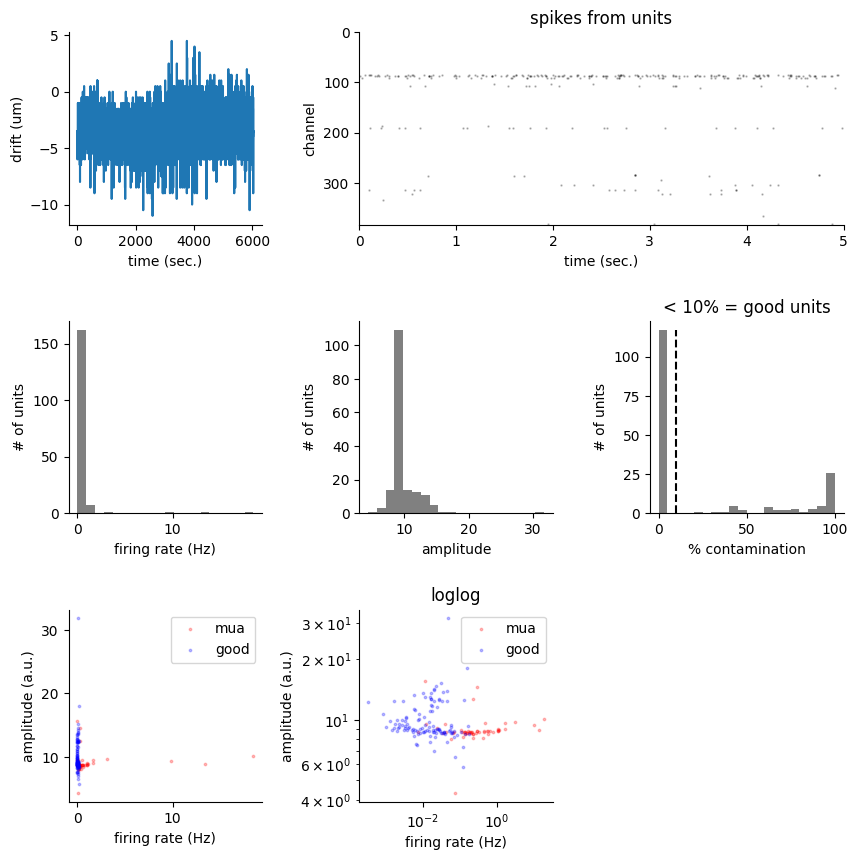

~~~~~~~~~~~~~~ good units ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
title = number of spikes from each unit


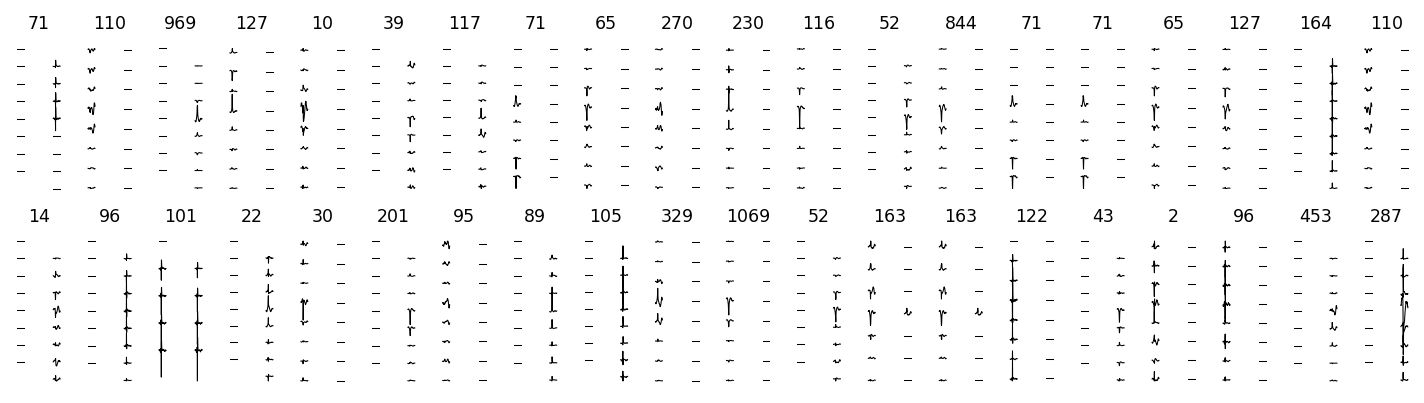

~~~~~~~~~~~~~~ mua units ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
title = number of spikes from each unit


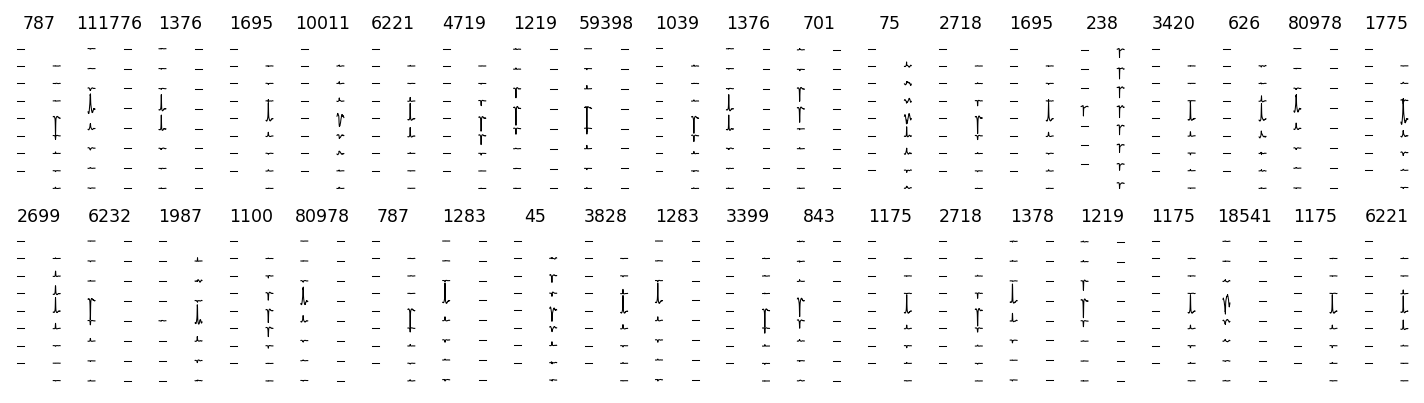

imec1 folder: /Users/rahimhashim/Downloads/gandalf_20231223_g0/gandalf_20231223_g0_imec1


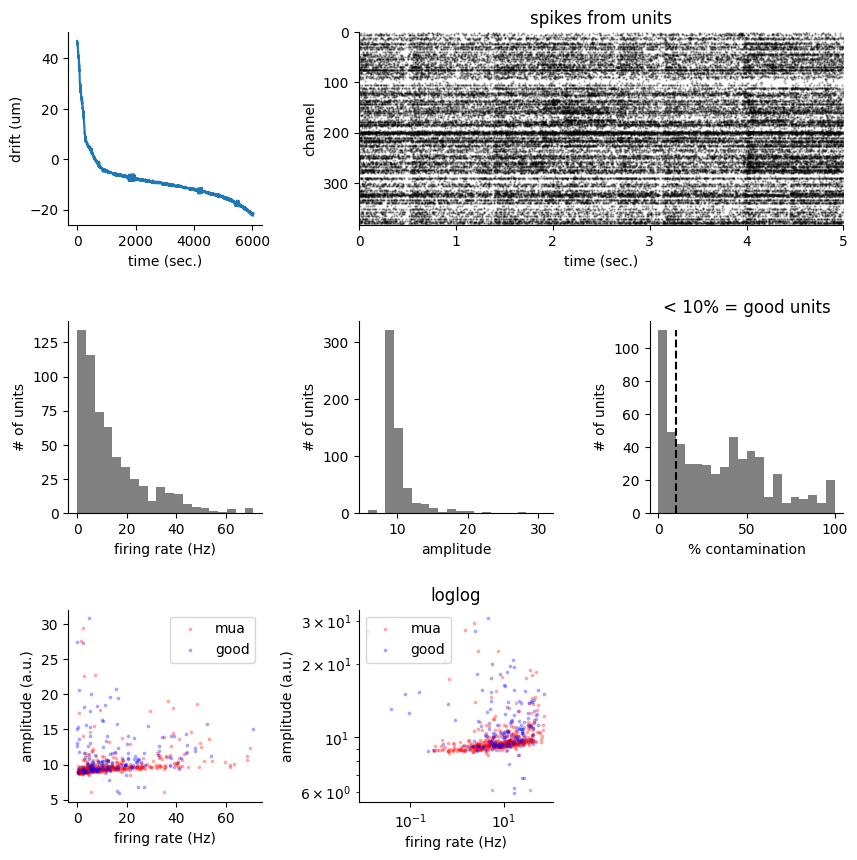

~~~~~~~~~~~~~~ good units ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
title = number of spikes from each unit


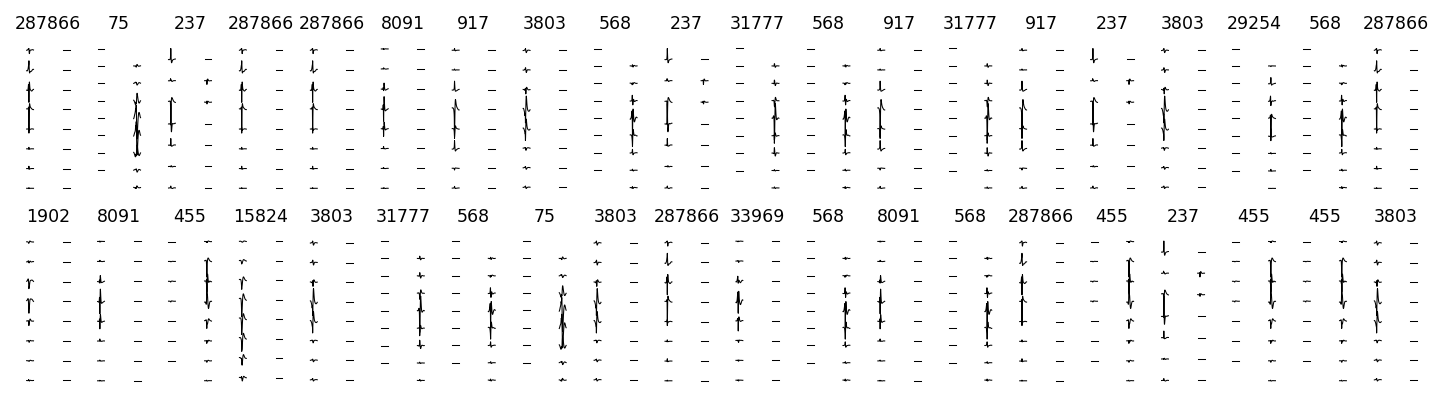

~~~~~~~~~~~~~~ mua units ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
title = number of spikes from each unit


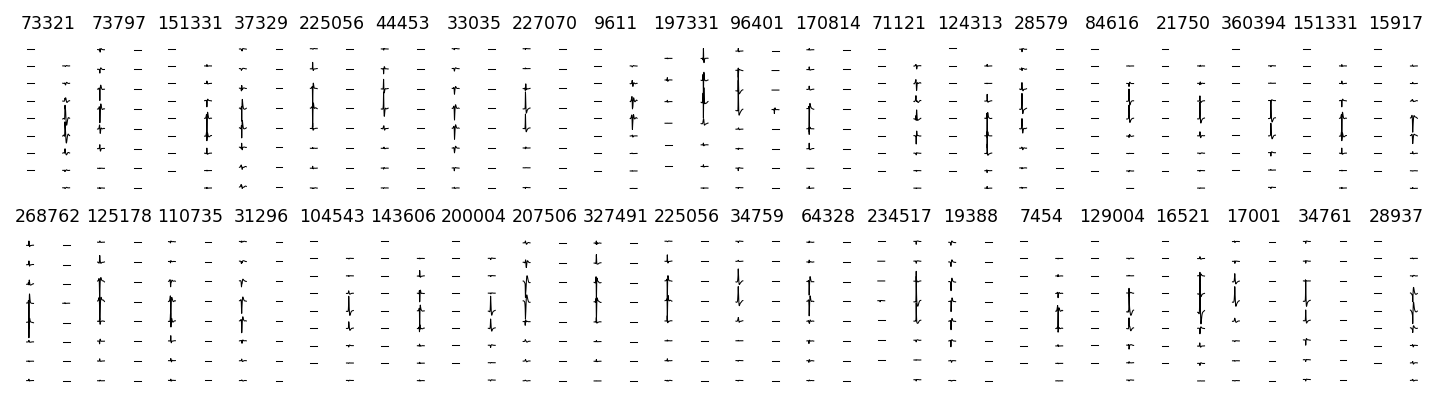

In [7]:
def plot_results(settings):

	# load results
	results_dir = settings['results_dir']
	fig_save_dir = os.path.join(results_dir, 'ks4_figures')

	# outputs saved to results_dir
	ops = np.load(os.path.join(results_dir, 'ops.npy'), allow_pickle=True).item()
	camps = pd.read_csv(os.path.join(results_dir, 'cluster_Amplitude.tsv'), sep='\t')['Amplitude'].values
	contam_pct = pd.read_csv(os.path.join(results_dir, 'cluster_ContamPct.tsv'), sep='\t')['ContamPct'].values
	chan_map =  np.load(os.path.join(results_dir, 'channel_map.npy'))
	templates =  np.load(os.path.join(results_dir, 'templates.npy'))
	chan_best = (templates**2).sum(axis=1).argmax(axis=-1)
	chan_best = chan_map[chan_best]
	amplitudes = np.load(os.path.join(results_dir, 'amplitudes.npy'))
	st = np.load(os.path.join(results_dir, 'spike_times.npy'))
	clu = np.load(os.path.join(results_dir, 'spike_clusters.npy'))
	firing_rates = np.unique(clu, return_counts=True)[1] * 30000 / st.max()
	dshift = ops['dshift']

	# plot summary figure
	rcParams['axes.spines.top'] = False
	rcParams['axes.spines.right'] = False
	gray = .5 * np.ones(3)

	fig = plt.figure(figsize=(10,10), dpi=100)
	grid = gridspec.GridSpec(3, 3, figure=fig, hspace=0.5, wspace=0.5)

	ax = fig.add_subplot(grid[0,0])
	ax.plot(np.arange(0, ops['Nbatches'])*2, dshift)
	ax.set_xlabel('time (sec.)')
	ax.set_ylabel('drift (um)')

	ax = fig.add_subplot(grid[0,1:])
	t0 = 0
	t1 = np.nonzero(st > ops['fs']*5)[0][0]
	ax.scatter(st[t0:t1]/30000., chan_best[clu[t0:t1]], s=0.5, color='k', alpha=0.25)
	ax.set_xlim([0, 5])
	ax.set_ylim([chan_map.max(), 0])
	ax.set_xlabel('time (sec.)')
	ax.set_ylabel('channel')
	ax.set_title('spikes from units')

	ax = fig.add_subplot(grid[1,0])
	nb=ax.hist(firing_rates, 20, color=gray)
	ax.set_xlabel('firing rate (Hz)')
	ax.set_ylabel('# of units')

	ax = fig.add_subplot(grid[1,1])
	nb=ax.hist(camps, 20, color=gray)
	ax.set_xlabel('amplitude')
	ax.set_ylabel('# of units')

	ax = fig.add_subplot(grid[1,2])
	nb=ax.hist(np.minimum(100, contam_pct), np.arange(0,105,5), color=gray)
	ax.plot([10, 10], [0, nb[0].max()], 'k--')
	ax.set_xlabel('% contamination')
	ax.set_ylabel('# of units')
	ax.set_title('< 10% = good units')

	for k in range(2):
		ax = fig.add_subplot(grid[2,k])
		is_ref = contam_pct<10.
		ax.scatter(firing_rates[~is_ref], camps[~is_ref], s=3, color='r', label='mua', alpha=0.25)
		ax.scatter(firing_rates[is_ref], camps[is_ref], s=3, color='b', label='good', alpha=0.25)
		ax.set_ylabel('amplitude (a.u.)')
		ax.set_xlabel('firing rate (Hz)')
		ax.legend()
		if k==1:
			ax.set_xscale('log')
			ax.set_yscale('log')
			ax.set_title('loglog')
	# save figure to fig_save_dir
	if not os.path.exists(fig_save_dir):
		os.makedirs(fig_save_dir)
	plt.savefig(os.path.join(fig_save_dir, 'summary.png'))
	plt.show()

	# plot templates
	probe = ops['probe']
	# x and y position of probe sites
	xc, yc = probe['xc'], probe['yc']
	nc = 16 # number of channels to show
	good_units = np.nonzero(contam_pct <= 0.1)[0]
	mua_units = np.nonzero(contam_pct > 0.1)[0]

	gstr = ['good', 'mua']
	for j in range(2):
		print(f'~~~~~~~~~~~~~~ {gstr[j]} units ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
		print('title = number of spikes from each unit')
		units = good_units if j==0 else mua_units
		fig = plt.figure(figsize=(12,3), dpi=150)
		grid = gridspec.GridSpec(2,20, figure=fig, hspace=0.25, wspace=0.5)

		for k in range(40):
			wi = units[np.random.randint(len(units))]
			wv = templates[wi].copy()
			cb = chan_best[wi]
			nsp = (clu==wi).sum()

			ax = fig.add_subplot(grid[k//20, k%20])
			n_chan = wv.shape[-1]
			ic0 = max(0, cb-nc//2)
			ic1 = min(n_chan, cb+nc//2)
			wv = wv[:, ic0:ic1]
			x0, y0 = xc[ic0:ic1], yc[ic0:ic1]

			amp = 4
			for ii, (xi,yi) in enumerate(zip(x0,y0)):
				t = np.arange(-wv.shape[0]//2,wv.shape[0]//2,1,'float32')
				t /= wv.shape[0] / 20
				ax.plot(xi + t, yi + wv[:,ii]*amp, lw=0.5, color='k')

			ax.set_title(f'{nsp}', fontsize='small')
			ax.axis('off')
		# save figure to results_dir
		plt.savefig(os.path.join(fig_save_dir, f'templates_{gstr[j]}.png'))
		plt.show()

def run_kilosort4(imec_num, settings, results):
	default_kilosort_settings = {'n_chan_bin': 385}
	try:
		ops, st, clu, tF, Wall, similar_templates, is_ref, est_contam_rate = \
				run_kilosort(settings=default_kilosort_settings,
										probe_name=settings['probe_name'],
										filename=settings['filename'],
										results_dir=settings['results_dir'],
										do_CAR=settings['do_CAR'],)
		results[imec_num] = {
			'ops': ops,
			'st': st, 
			'clu': clu, 
			'tF': tF, 
			'Wall': Wall, 
			'similar_templates': similar_templates, 
			'is_ref': is_ref, 
			'est_contam_rate': est_contam_rate
		}
	except:
		print(f'Error in running Kilosort4 for {imec_num}')
	return results

def run_ks4_py(run_ks4, session_params, imec_folder_dict, map_file, n_channels=385):
	root = session_params['root']
	monkey = session_params['monkey']
	date = session_params['date']
	session_num = session_params['session_num']

	for imec_num, imec_folder in imec_folder_dict.items():
		print(f'{imec_num} folder: {imec_folder}')
		data_dir = imec_folder
		save_path = os.path.join(imec_folder, f'{monkey}_{date}_g{session_num}_{imec_num}_ks4')
		bin_file = os.path.join(imec_folder, f'{monkey}_{date}_g{session_num}_t0.{imec_num}.ap.bin')
		# if not os.path.exists(bin_file):
		# 	print(f'{bin_file} does not exist')
		# 	continue
		settings = {'filename': bin_file,
								'results_dir': save_path,
								'do_CAR': True,
								'n_channels': n_channels,
								'probe_name': map_file}
		# run kilosort4
		if run_ks4:
			results = run_kilosort4(imec_num, settings, results)
		plot_results(settings)

run_ks4 = False
map_file = os.path.join(os.getcwd(), 'configFiles/neuropixels_NHP_channel_map_linear_v1.mat')
n_channels = 385
results = defaultdict(lambda: defaultdict(dict))

run_ks4_py(run_ks4, session_params, imec_folder_dict, map_file, n_channels)

***
## Run TPrime

In [12]:
sys.path.append(os.path.join(ks_path, 'SpikeGLX_Datafile_Tools/Python/DemoReadSGLXData'))
sys.path.append(os.path.join(ks_path, 'TPrime-win'))
from readSGLX import readMeta

def tprime_py(run_tprime, sglx_folder, imec_folder_dict, ks_path, monkey, date, session_num):
	if run_tprime:
		tprime_struct = defaultdict(list)
		tprime_path = os.path.join(ks_path, 'TPrime-win')
		# find all files in the session folder that have the string 'tcat.nidq.xd'
		try:
			tprime_struct['nidq'] = os.path.join(sglx_folder, 
														[f for f in os.listdir(sglx_folder) if 'tcat.nidq.xd' in f][0])
		except:
				print('   WARNING: Missing tcat.nidq.xd file. TPrime will not run.')
		for imec_num, imec_folder in imec_folder_dict.items():
			meta_file = [f for f in os.listdir(imec_folder) if f.endswith('.meta')][0]
			bin_file = os.path.join(imec_folder, f'{monkey}_{date}_g{session_num}_t0.{imec_num}.ap.bin')
			print(f'Reading {bin_file}')
			bin_file_path = Path(bin_file)
			meta_file = readMeta(bin_file_path)
			print("\tConverting spike times to seconds...")
			sample_rate = float(meta_file['imSampRate'])
			print(f"\tSampling rate: {sample_rate:.2f}")
			save_path = os.path.join(imec_folder, f'{monkey}_{date}_g{session_num}_{imec_num}_ks4')
			spike_times = np.load(os.path.join(save_path, 'spike_times.npy'))
			# keep full precision
			# spike_times_sec = spike_times / sample_rate
			spike_times_sec_file = os.path.join(save_path, "spike_times_sec.txt")
			# with open(spike_times_sec_file, 'w') as f:
			# 		for spike_time in spike_times_sec:
			# 				f.write(f"{spike_time}\n")
			print(f"\t\tGenerating {spike_times_sec_file}")
			print("\t\tDone.")
			tprime_struct['sec_files'].append(spike_times_sec_file)
			# add all files that have the string 'tcat.<imec_num>.ap.xd*' in them
			tprime_struct['imec'].append(os.path.join(imec_folder,
															[f for f in os.listdir(imec_folder) if 'tcat' in f and 'ap.xd' in f][0]))
		print(f'TPrime struct: {tprime_struct}')
		print(f'Running TPrime...')
		# time how long it takes
		start_time = time.time()
		# to run TPrime and generate spike_times_adj.npy
		tprime_command = f'runit.bat -syncperiod=1.0 -tostream={tprime_struct["nidq"]}'
		if not tprime_struct['sec_files']:
			sys.exit('No spike_times_sec.txt files found')
		if not tprime_struct['imec']:
			sys.exit('No imec files found')
		for idx, imec in enumerate(tprime_struct['imec']):
			tprime_sec_final = tprime_struct['sec_files'][idx].replace('.txt', '_adj.txt')
			tprime_command += f' -fromstream={idx},{tprime_struct["imec"][idx]}'
			tprime_command += f' -events={idx},{tprime_struct["sec_files"][idx]},{tprime_sec_final}'
		# to extract sync signals and not run CatGT 
		print(f"  Bash command: {tprime_command}")
		subprocess.run(tprime_command, cwd=tprime_path, shell=True)
		print(f"  TPrime complete. Time elapsed: {time.time() - start_time:.2f} seconds")

run_tprime = True
sglx_tools = os.path.join(ks_path, 'SpikeGLX_Datafile_Tools/Python/DemoReadSGLXData')
sys.path.append(sglx_tools)

tprime_py(run_tprime, sglx_folder, imec_folder_dict, ks_path, session_params['monkey'], session_params['date'], session_params['session_num'])

IndexError: list index out of range